In [1]:
import tensorflow as tf
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, LearningRateScheduler
from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib.pyplot import figure

In [67]:
# Loading the data, splitting up into test and trainign set 
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#print(len(train_images), len(test_images))   #checking original sizes 

In [68]:
# split training data into training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=0)

In [4]:
#Setting class names so we can get an overview of the data
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
train_images[0].shape


(28, 28)

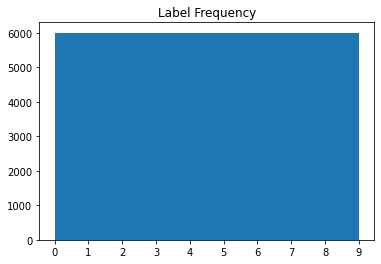

In [6]:
#Checking label distribution, uniform distribution 
train, test = fashion_mnist.load_data()
data = tf.data.Dataset.from_tensor_slices(train)

vals = np.fromiter(data.map(lambda x, y: y), float)

plt.hist(vals)
plt.xticks(range(10))
plt.title('Label Frequency')
plt.show()

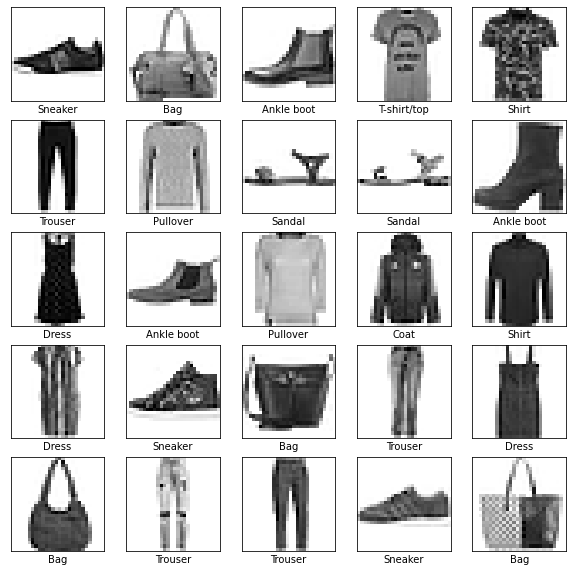

In [7]:

#Plotting a subset of data with labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


In [69]:
#scale to range 0 - 1 
train_images = train_images / 255.0
validation_images = validation_images / 255.0
test_images = test_images / 255.0

In [9]:
#display some images
def display_image(position):
    image = train_images[position]
    plt.title('Example %d. Label: %s' % (position, class_names[train_labels[position]]))
    plt.imshow(image, cmap=plt.cm.gray_r)

In [10]:
#display_image(22)

In [11]:
# explore the data
print('# of training images:', train_images.shape[0])
print('# of validation images:', validation_images.shape[0])
print('# of test images:', test_images.shape[0])

# of training images: 48000
# of validation images: 12000
# of test images: 10000


In [70]:
print(f"Image shape before: {train_images[0].shape}")

# Pad images with 0s since we want information in the edges, output size should now be 32,32
train_images      = np.pad(train_images, ((0,0),(2,2),(2,2)), 'constant')
validation_images = np.pad(validation_images, ((0,0),(2,2),(2,2)), 'constant')
test_images       = np.pad(test_images, ((0,0),(2,2),(2,2)), 'constant')

print(f"Updated Image Shape: {train_images[0].shape}.")


Image shape before: (28, 28)
Updated Image Shape: (32, 32).


In [13]:
#Baseline model architecture
bl_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),                      
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Print model summary
bl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [71]:
#Compile model, use optimiser Adam
bl_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Setting number of epochs and batch size
EPOCHS = 15
BATCH_SIZE = 128

#add channel = 1 for greyscale
train_images=train_images[:,:,:,None]
validation_images=validation_images[:,:,:,None]
print("Training images shape: ", train_images.shape)
print("Validation images shape ", validation_images.shape)

X_train, y_train = train_images, to_categorical(train_labels)
X_validation, y_validation = validation_images, to_categorical(validation_labels)



Training images shape:  (48000, 32, 32, 1)
Validation images shape  (12000, 32, 32, 1)


In [15]:
#Fitting the model, performing training
bl_history=bl_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Epoch 1/15
375/375 [==============================] - 12s 8ms/step - loss: 0.7702 - accuracy: 0.7491 - val_loss: 0.5756 - val_accuracy: 0.8169
Epoch 2/15
375/375 [==============================] - 3s 8ms/step - loss: 0.5303 - accuracy: 0.8258 - val_loss: 0.4999 - val_accuracy: 0.8342
Epoch 3/15
375/375 [==============================] - 3s 8ms/step - loss: 0.4724 - accuracy: 0.8465 - val_loss: 0.4604 - val_accuracy: 0.8491
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.4370 - accuracy: 0.8582 - val_loss: 0.4404 - val_accuracy: 0.8570
Epoch 5/15
375/375 [==============================] - 3s 7ms/step - loss: 0.4070 - accuracy: 0.8671 - val_loss: 0.4055 - val_accuracy: 0.8681
Epoch 6/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3880 - accuracy: 0.8730 - val_loss: 0.3867 - val_accuracy: 0.8742
Epoch 7/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3727 - accuracy: 0.8766 - val_loss: 0.3902 - val_accuracy: 0.8732
Epoch

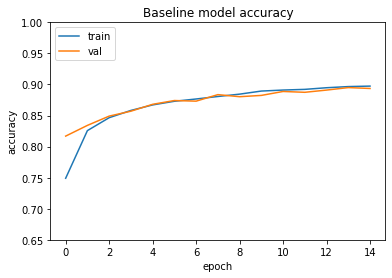

In [16]:
#Plotting the accuracy baseline model
plt.plot(bl_history.history['accuracy'])
plt.plot(bl_history.history['val_accuracy'])
plt.title('Baseline model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

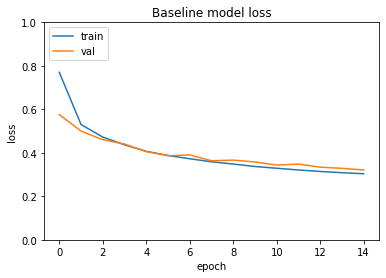

In [17]:
#Plotting the loss for baseline model
plt.plot(bl_history.history['loss'])
plt.plot(bl_history.history['val_loss'])
plt.title('Baseline model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

In [18]:
#Printing the val & training loss and accuracy for baseline model 
print(f"Baseline model training accuracy: {bl_history.history['accuracy'][-1]} and validation accuracy: {bl_history.history['val_accuracy'][-1]}")
print(f"Baseline model training loss: {bl_history.history['loss'][-1]} and validation loss: {bl_history.history['val_loss'][-1]}")

Baseline model training accuracy: 0.8973958492279053 and validation accuracy: 0.893583357334137
Baseline model training loss: 0.3039300739765167 and validation loss: 0.3212078809738159


In [19]:
#Save weights of model
bl_model.save_weights("bl_model.h5")

In [96]:
#Model2 DropOut model architecture
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Dropout(0.2),                       
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])
dropout_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_11 (Avera  (None, 15, 15, 6)        0         
 gePooling2D)                                                    
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 6)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_12 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 16)         

In [97]:
#Compile and fit model
dropout_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
dropout_history=dropout_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Epoch 1/15
375/375 [==============================] - 5s 12ms/step - loss: 1.0120 - accuracy: 0.6431 - val_loss: 0.6710 - val_accuracy: 0.7585
Epoch 2/15
375/375 [==============================] - 3s 8ms/step - loss: 0.7045 - accuracy: 0.7447 - val_loss: 0.5852 - val_accuracy: 0.7782
Epoch 3/15
375/375 [==============================] - 3s 8ms/step - loss: 0.6366 - accuracy: 0.7706 - val_loss: 0.5283 - val_accuracy: 0.8117
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.6031 - accuracy: 0.7813 - val_loss: 0.5017 - val_accuracy: 0.8264
Epoch 5/15
375/375 [==============================] - 3s 8ms/step - loss: 0.5772 - accuracy: 0.7922 - val_loss: 0.4959 - val_accuracy: 0.8264
Epoch 6/15


KeyboardInterrupt: ignored

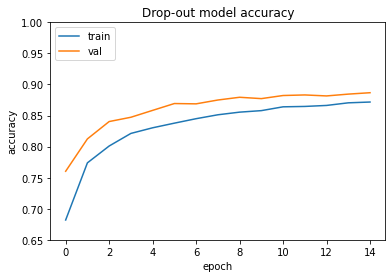

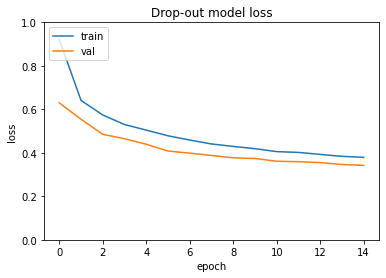

Dropout model training accuracy: 0.871749997138977 and validation accuracy: 0.8867499828338623
Dropout model training loss: 0.37917810678482056 and validation loss: 0.34218889474868774


In [22]:
#Plotting the accuracy of dropout model
plt.plot(dropout_history.history['accuracy'])
plt.plot(dropout_history.history['val_accuracy'])
plt.title('Drop-out model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

#Plotting the loss of dropout model
plt.plot(dropout_history.history['loss'])
plt.plot(dropout_history.history['val_loss'])
plt.title('Drop-out model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

#Printing the val & training loss and accuracy of dropout model
print(f"Dropout model training accuracy: {dropout_history.history['accuracy'][-1]} and validation accuracy: {dropout_history.history['val_accuracy'][-1]}")
print(f"Dropout model training loss: {dropout_history.history['loss'][-1]} and validation loss: {dropout_history.history['val_loss'][-1]}")

In [23]:
#Saving weights of dropout model
dropout_model.save_weights("dropout_model.h5")

In [24]:
#Model3 MaxPooling model architecture
maxpool_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D(),                      
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

maxpool_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 6)        0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [25]:
#Compiling and fitting Maxpool model
maxpool_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
maxpool_history=maxpool_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Epoch 1/15
375/375 [==============================] - 4s 9ms/step - loss: 0.7330 - accuracy: 0.7698 - val_loss: 0.5434 - val_accuracy: 0.8213
Epoch 2/15
375/375 [==============================] - 3s 7ms/step - loss: 0.4655 - accuracy: 0.8527 - val_loss: 0.4442 - val_accuracy: 0.8622
Epoch 3/15
375/375 [==============================] - 3s 7ms/step - loss: 0.4205 - accuracy: 0.8667 - val_loss: 0.4114 - val_accuracy: 0.8697
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.3903 - accuracy: 0.8767 - val_loss: 0.3888 - val_accuracy: 0.8777
Epoch 5/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3725 - accuracy: 0.8821 - val_loss: 0.3875 - val_accuracy: 0.8741
Epoch 6/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3545 - accuracy: 0.8858 - val_loss: 0.3825 - val_accuracy: 0.8754
Epoch 7/15
375/375 [==============================] - 3s 7ms/step - loss: 0.3445 - accuracy: 0.8898 - val_loss: 0.3521 - val_accuracy: 0.8902
Epoch 

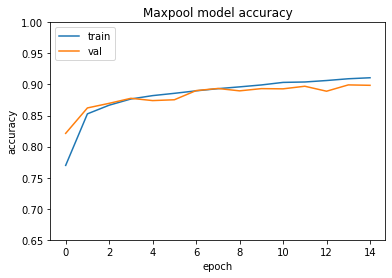

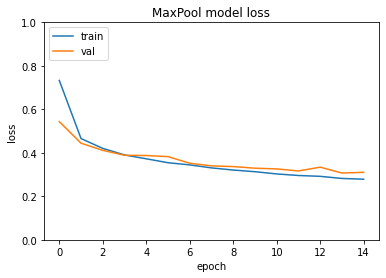

Maxpool model training accuracy: 0.9108333587646484 and validation accuracy: 0.8986666798591614
Maxpool model training loss: 0.2786867022514343 and validation loss: 0.31025266647338867


In [26]:
#Plotting the accuracy of maxpool model
plt.plot(maxpool_history.history['accuracy'])
plt.plot(maxpool_history.history['val_accuracy'])
plt.title('Maxpool model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

#Plotting the loss of maxpool model
plt.plot(maxpool_history.history['loss'])
plt.plot(maxpool_history.history['val_loss'])
plt.title('MaxPool model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

#Printing the val & training loss and accuracy of maxpool model
print(f"Maxpool model training accuracy: {maxpool_history.history['accuracy'][-1]} and validation accuracy: {maxpool_history.history['val_accuracy'][-1]}")
print(f"Maxpool model training loss: {maxpool_history.history['loss'][-1]} and validation loss: {maxpool_history.history['val_loss'][-1]}")

In [27]:
#Save weights of maxpool model
maxpool_model.save_weights("maxpool_model.h5")

In [28]:
#Model4 More filters model architecture
filter_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),                      
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

filter_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 average_pooling2d_4 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [29]:
#Compile and fit filter model
filter_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
filter_history=filter_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Epoch 1/15
375/375 [==============================] - 6s 15ms/step - loss: 0.7664 - accuracy: 0.7644 - val_loss: 0.5421 - val_accuracy: 0.8188
Epoch 2/15
375/375 [==============================] - 5s 13ms/step - loss: 0.4946 - accuracy: 0.8401 - val_loss: 0.4629 - val_accuracy: 0.8541
Epoch 3/15
375/375 [==============================] - 5s 14ms/step - loss: 0.4439 - accuracy: 0.8554 - val_loss: 0.4273 - val_accuracy: 0.8616
Epoch 4/15
375/375 [==============================] - 5s 13ms/step - loss: 0.4156 - accuracy: 0.8650 - val_loss: 0.4278 - val_accuracy: 0.8571
Epoch 5/15
375/375 [==============================] - 5s 14ms/step - loss: 0.3931 - accuracy: 0.8719 - val_loss: 0.3917 - val_accuracy: 0.8754
Epoch 6/15
375/375 [==============================] - 5s 13ms/step - loss: 0.3758 - accuracy: 0.8771 - val_loss: 0.4039 - val_accuracy: 0.8648
Epoch 7/15
375/375 [==============================] - 5s 14ms/step - loss: 0.3638 - accuracy: 0.8815 - val_loss: 0.3672 - val_accuracy: 0.8816

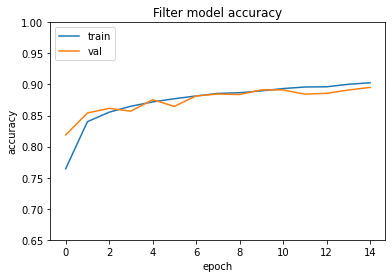

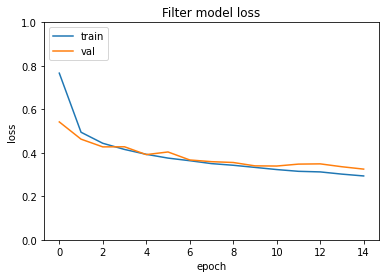

Filter model training accuracy: 0.9027708172798157 and validation accuracy: 0.8953333497047424
Filter model training loss: 0.2936202585697174 and validation loss: 0.3250376880168915


In [30]:
#Plotting the accuracy of filter model
plt.plot(filter_history.history['accuracy'])
plt.plot(filter_history.history['val_accuracy'])
plt.title('Filter model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

#Plotting the loss of filter model
plt.plot(filter_history.history['loss'])
plt.plot(filter_history.history['val_loss'])
plt.title('Filter model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

#Printing the val & training loss and accuracy of filter model
print(f"Filter model training accuracy: {filter_history.history['accuracy'][-1]} and validation accuracy: {filter_history.history['val_accuracy'][-1]}")
print(f"Filter model training loss: {filter_history.history['loss'][-1]} and validation loss: {filter_history.history['val_loss'][-1]}")

In [31]:
#Saving weights of filter model
filter_model.save_weights("filter_model.h5")

In [32]:
#Model5 1 more convolutional layer model architecture
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),   
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),                   
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_6 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_7 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 32)          4640      
                                                                 
 average_pooling2d_8 (Averag  (None, 2, 2, 32)        

In [33]:
#Compiling and fitting conv model
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
conv_history=conv_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation))

Epoch 1/15
375/375 [==============================] - 4s 8ms/step - loss: 1.0162 - accuracy: 0.6826 - val_loss: 0.7874 - val_accuracy: 0.7278
Epoch 2/15
375/375 [==============================] - 3s 8ms/step - loss: 0.7438 - accuracy: 0.7481 - val_loss: 0.7367 - val_accuracy: 0.7551
Epoch 3/15
375/375 [==============================] - 3s 8ms/step - loss: 0.6898 - accuracy: 0.7639 - val_loss: 0.6584 - val_accuracy: 0.7656
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.6488 - accuracy: 0.7787 - val_loss: 0.6364 - val_accuracy: 0.7729
Epoch 5/15
375/375 [==============================] - 3s 8ms/step - loss: 0.6222 - accuracy: 0.7866 - val_loss: 0.6328 - val_accuracy: 0.7795
Epoch 6/15
375/375 [==============================] - 3s 8ms/step - loss: 0.5939 - accuracy: 0.7989 - val_loss: 0.5954 - val_accuracy: 0.7910
Epoch 7/15
375/375 [==============================] - 3s 8ms/step - loss: 0.5757 - accuracy: 0.8039 - val_loss: 0.5802 - val_accuracy: 0.8059
Epoch 

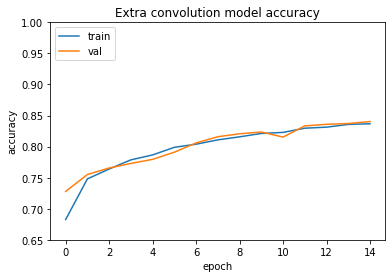

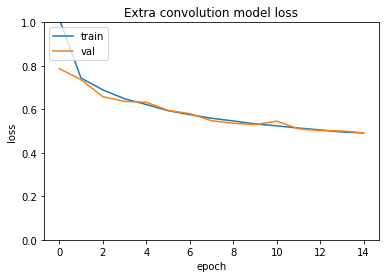

Extra convolution model training accuracy: 0.8367916941642761 and validation accuracy: 0.8403333425521851
Extra convolution model training loss: 0.49157851934432983 and validation loss: 0.49185627698898315


In [34]:
#Plotting the accuracy of conv model
plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('Extra convolution model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

#Plotting the loss of conv model
plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Extra convolution model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

#Printing the val & training loss and accuracy of conv model
print(f"Extra convolution model training accuracy: {conv_history.history['accuracy'][-1]} and validation accuracy: {conv_history.history['val_accuracy'][-1]}")
print(f"Extra convolution model training loss: {conv_history.history['loss'][-1]} and validation loss: {conv_history.history['val_loss'][-1]}")

In [35]:
#Saving weights of conv model
conv_model.save_weights("conv_model.h5")

In [36]:
#Learningrate decay model architecture
lr_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.AveragePooling2D(),                      
    tf.keras.layers.Flatten(), #or Flatten(input_shape=(28, 28))
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


lr_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_9 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_10 (Avera  (None, 6, 6, 16)         0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 576)               0         
                                                                 
 dense_15 (Dense)            (None, 120)              

In [37]:
"""Schedule function to reduce the learning rate to half every 5 epochs"""

def scheduler(epoch, lr):
  if epoch > 0 and (epoch % 5 == 0):
    return lr * 0.5
  else:
    return lr

#Create callback for adapting learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [38]:
"""Set initial learningrate to 0.1, use SGD here instead of Adam as Adam has internal learning rate management that is not compatible with most learning rate schedules"""
opt = tf.keras.optimizers.SGD(learning_rate=0.1) #Can also try with 0.01
lr_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
lr_history=lr_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_validation, y_validation), callbacks=[callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/15
375/375 [==============================] - 4s 8ms/step - loss: 0.9727 - accuracy: 0.6705 - val_loss: 0.7859 - val_accuracy: 0.7143 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 2/15
375/375 [==============================] - 3s 7ms/step - loss: 0.6234 - accuracy: 0.7827 - val_loss: 0.5975 - val_accuracy: 0.7947 - lr: 0.1000

Epoch 3: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 3/15
375/375 [==============================] - 3s 7ms/step - loss: 0.5498 - accuracy: 0.8091 - val_loss: 0.5353 - val_accuracy: 0.8186 - lr: 0.1000

Epoch 4: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.5064 - accuracy: 0.8254 - val_loss: 0.5255 - val_accuracy: 0.8116 - lr: 0.1000

Epoch 5: LearningRateScheduler setting learning rate to 0.100000001

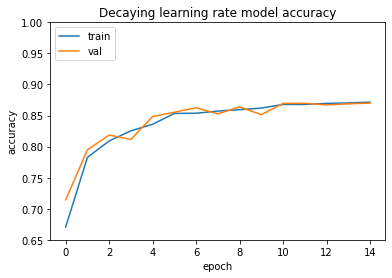

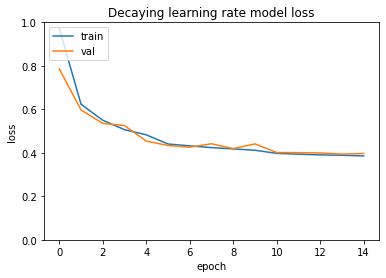

Decaying lr model training accuracy: 0.8715624809265137 and validation accuracy: 0.8700833320617676
Decaying lr model training loss: 0.3858011066913605 and validation loss: 0.39701521396636963


In [39]:
#Plotting the accuracy for lr_model
plt.plot(lr_history.history['accuracy'])
plt.plot(lr_history.history['val_accuracy'])
plt.title('Decaying learning rate model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0.65, 1])
plt.show()

#Plotting the loss for lr_model
plt.plot(lr_history.history['loss'])
plt.plot(lr_history.history['val_loss'])
plt.title('Decaying learning rate model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.show()

#Printing the val & training loss and accuracy 
print(f"Decaying lr model training accuracy: {lr_history.history['accuracy'][-1]} and validation accuracy: {lr_history.history['val_accuracy'][-1]}")
print(f"Decaying lr model training loss: {lr_history.history['loss'][-1]} and validation loss: {lr_history.history['val_loss'][-1]}")

In [155]:
#save learning rate model
lr_model.save_weights("lr_model.h5")

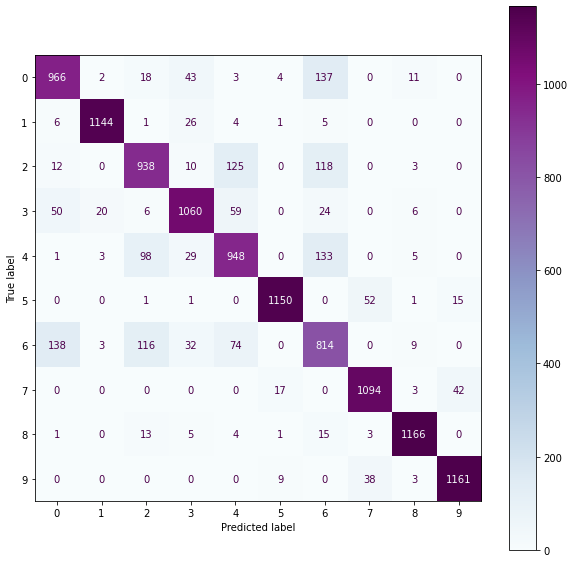

In [48]:
#Make confusion matrix with scikitlearn that shows number of images classified correctly and incorrectly
y_pred = lr_model.predict(validation_images)
y_true = validation_labels             
y_pred_class = np.argmax(y_pred, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(validation_labels, y_pred_class, cmap="BuPu", ax=ax)  #BuPu, pink_r, PuBu, binary, Greens, CMRmap_r
plt.show()

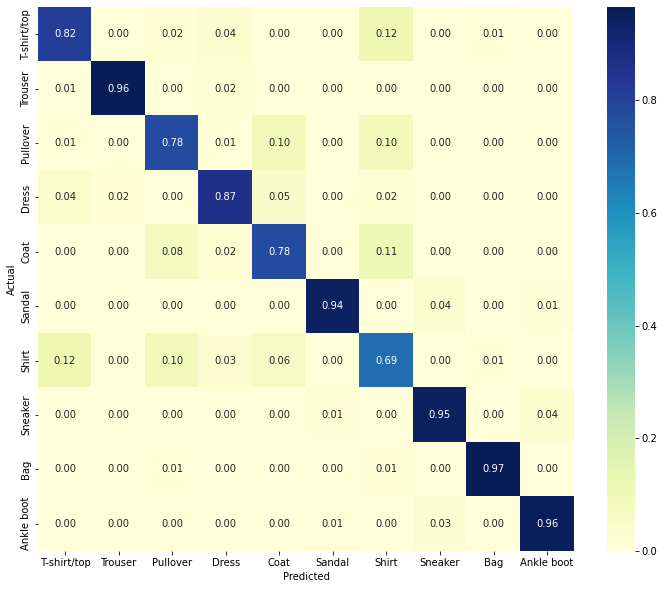

In [42]:
#Normalised heatmap using seaborn that shows percentage of correctly classified (and missclassified) labels
cm = confusion_matrix(validation_labels, y_pred_class)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu") #YlGnBu, Blues, CMRmap_r, pink_r, binary, BuPu, PuBu, Reds
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [132]:
%matplotlib inline

The shape of the conv2d_11 is =======>> (1, 30, 30, 6)
The shape of the average_pooling2d_9 is =======>> (1, 15, 15, 6)
The shape of the conv2d_12 is =======>> (1, 13, 13, 16)
The shape of the average_pooling2d_10 is =======>> (1, 6, 6, 16)
The shape of the flatten_5 is =======>> (1, 576)
The shape of the dense_15 is =======>> (1, 120)
The shape of the dense_16 is =======>> (1, 84)
The shape of the dense_17 is =======>> (1, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


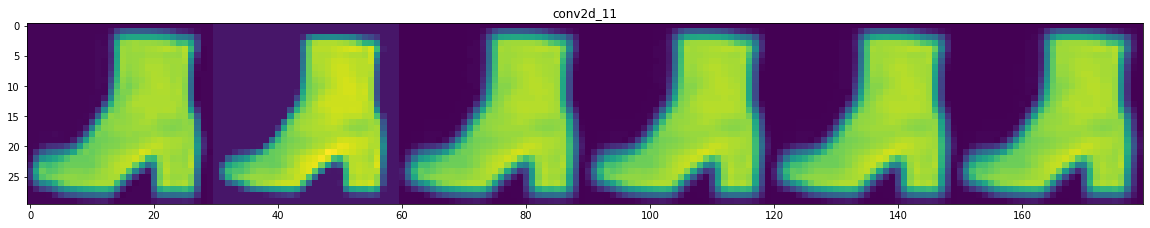

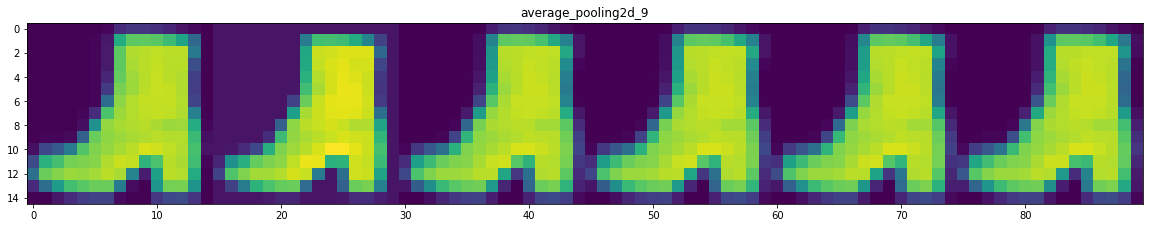

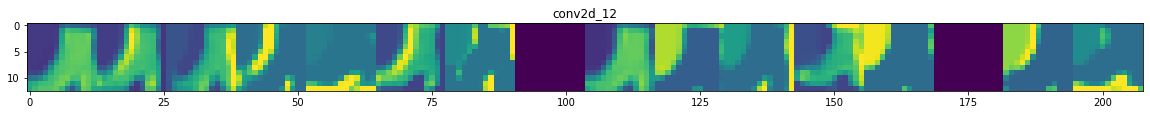

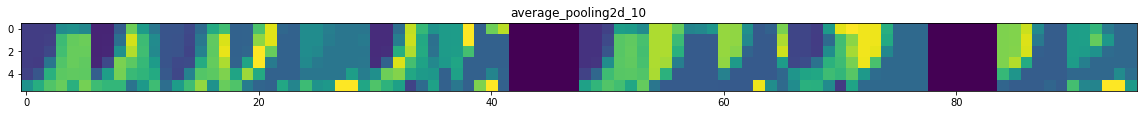

In [152]:
"""Building visualisation for output layers"""

#Take arbitrary image and add  empty dimension so that it can be predicted 
img = train_images[9][None,:,:,:]

#Get the name of the layers
layer_names = [layer.name for layer in lr_model.layers]

#print(lr_model.layers) #Checking the different layers
layer_outputs = [layer.output for layer in lr_model.layers] #Create list of the outputs for all layers
visualisation_model = tf.keras.models.Model(inputs=lr_model.input, outputs=layer_outputs) #Creating a model for visualisation with the same input as analysed model and output all the intermediate layers of model


feature_maps = visualisation_model.predict(img) #pass image into the visualisation model to get the feature maps

for layer_name, feature_map in zip(layer_names, feature_maps):
  print(f"The shape of the {layer_name} is : {feature_map.shape}") #Print shape of each feature map for each output layer

 
  if len(feature_map.shape) == 4: #this makes sure we only get output from convolutional layers
    feature_dim = feature_map.shape[-1]  #Getting the number of feature dimensions for a featuremap of each layer
    size = feature_map.shape[1] 
    image_grid = np.zeros((size,size * feature_dim))  
    #img_array = []
    for i in range(feature_dim):   #iterate over a feature map of a layer and separate all feature images (filters). 
      img = feature_map[0, :, :, i]
      #since image is not very well defined here we need to standardise and normalise it so that we can understand it better
      img -= img.mean()
      img /= img.std ()
      img *=  64
      img += 128
      img = np.clip(img, 0, 255).astype('uint8')
      #Put image one by one into the image grid
      image_grid[:, i * size : (i + 1) * size] = img

    #Scale and plot image
    scale = 20. / feature_dim
    plt.figure(figsize=(scale * feature_dim, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(image_grid, aspect='auto')